# Get 5 min frequency for weather attributes for Feb 2018 from RWIS_atmos and RWIS_surface

    Created by: Apoorba Bibeka
    Date: April 24, 2019

In [15]:
import getpass
import boto3
import pandas as pd
from impala.dbapi import connect
from impala.util import as_pandas
from io import BytesIO as StringIO
import numpy as np
from matplotlib import pyplot as plt
from pandas import Series


## Connect to the database

In [2]:
username = "abibeka@securedatacommons.com"
password1 = getpass.getpass()
conn = connect(host="172.18.1.20",auth_mechanism='PLAIN',port=10000,user=username, password=password1)

········


In [3]:
cursor = conn.cursor()

In [4]:
# wydot_rwis_atmos has bad naming convention. local is a keyword in HIVE
#but is also used as a variable name. Thus use `` for accessing local.

In [5]:
cursor = conn.cursor()
cursor.execute('''select deviceid from wydot_speed_sensors_index
               where milepost between 314 and 360''')
# Store the index data tanle
SSindex = as_pandas(cursor)
SSindexL=SSindex.deviceid.tolist()
print(SSindexL)

[383L, 393L, 394L, 395L, 396L, 384L, 385L, 1839L, 386L, 2146L, 2147L, 2178L, 2191L, 387L, 2202L, 2213L, 2246L, 2263L, 2274L, 2289L, 2298L, 2310L, 2319L, 388L, 389L, 3654L, 390L, 3911L, 391L]


## Find the corresponding primary and secondary weather stations for speed sensor stations

In [6]:
q1='''SELECT deviceid, nearest_rwis, rwis, backup_rwis
        from wydot_speed_sensors_index'''
cursor.execute(q1)
dat=as_pandas(cursor)
dat1=dat[dat['deviceid'].isin(SSindexL)].copy()
rwis_sta=dat1.nearest_rwis.tolist()+dat1.backup_rwis.tolist()
rwis_sta = [int(x.strip('R00')) for x in rwis_sta]
print(rwis_sta,len(np.unique(rwis_sta)))

([1354, 36, 1354, 1354, 1354, 1354, 1354, 3451, 3422, 1354, 1354, 36, 3422, 343, 3422, 3422, 1366, 1366, 3443, 3443, 3443, 3443, 3451, 343, 343, 1354, 1366, 1354, 1366, 36, 3422, 36, 36, 36, 36, 36, 3443, 343, 36, 36, 3422, 343, 3422, 343, 343, 343, 3443, 1366, 1366, 3451, 3451, 3443, 3422, 1366, 36, 343, 36, 3443], 7)


## Remove the timezone ('-6:00' or '-7:00') from the end.
## Remove 'T' from between the date and time.

Figure out what to do with precip_type

In [32]:
timefilter="FROM_UNIXTIME(CEILING(UNIX_TIMESTAMP(regexp_replace(regexp_replace(`local`,'-0[67]:00$',''),'T',' '))/300)*300)"
start_date='2018-02-01'
end_date='2018-03-01' 
q1='''Select COUNT(*) AS ObsCount, {} AS Time5M
    FROM wydot_rwis_atmos 
    WHERE deviceid IN {} AND {} BETWEEN '{}' AND '{}'
    GROUP BY deviceid, {}'''.format(timefilter,tuple(rwis_sta),timefilter,start_date, end_date,timefilter)
cursor.execute(q1)
Xdat=as_pandas(cursor)

In [33]:
Xdat.head()

,obscount,time5m
0,2,2018-02-01 00:00:00
1,2,2018-02-01 00:05:00
2,2,2018-02-01 00:10:00
3,2,2018-02-01 00:15:00
4,2,2018-02-01 00:20:00


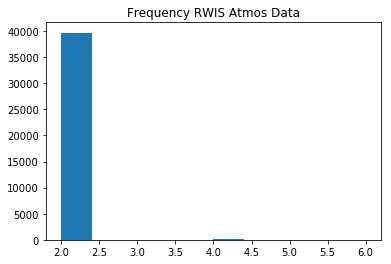

In [34]:
plt.hist(Xdat.obscount)
plt.title("Frequency RWIS Atmos Data")
plt.show()

In [35]:
Xdat.obscount.value_counts()

2    39693
4      217
6        3
Name: obscount, dtype: int64

In [36]:
timefilter="FROM_UNIXTIME(CEILING(UNIX_TIMESTAMP(regexp_replace(regexp_replace(`local`,'-0[67]:00$',''),'T',' '))/300)*300)"
start_date='2018-02-01'
end_date='2018-03-01' 
q1='''Select COUNT(*) AS ObsCount, {} AS Time5M
    FROM wydot_rwis_surface 
    WHERE deviceid IN {} AND {} BETWEEN '{}' AND '{}'
    GROUP BY deviceid, {}'''.format(timefilter,tuple(rwis_sta),timefilter,start_date, end_date,timefilter)
cursor.execute(q1)
Xdat1=as_pandas(cursor)

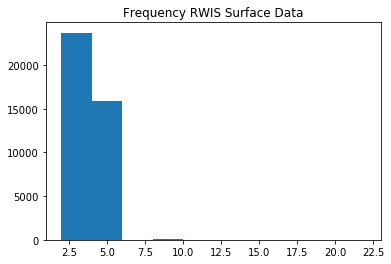

In [37]:
plt.hist(Xdat1.obscount)
plt.title("Frequency RWIS Surface Data")
plt.show()

In [38]:
Xdat1.obscount.value_counts()

2     23688
4     15922
8        76
6        26
10       15
12        7
16        5
18        4
14        4
22        1
Name: obscount, dtype: int64

In [39]:
Xdat1.shape

(39748, 2)

In [40]:
Xdat.shape

(39913, 2)